In [1]:
# Loads the autoreload extension in Notebook
%load_ext autoreload
# Sets the autoreload mode to reload all modules before executing code
%autoreload 2

In [2]:
from caits.loading import wav_specs_check

In [3]:
audio_params = wav_specs_check("data/yes.wav")

Information returned from the `wav_specs_check`:

* nchannels: number of audio channels (1 for mono, 2 for stereo)
* sampwidth: sample width in bytes
* framerate: sampling frequency
* nframes: number of audio frames
* comptype: compression type ('NONE' is the only supported type)
* compname: Human-readable version of `comptype`. Usually 'not compressed' parallels 'NONE'

In [4]:
audio_params

{'nchannels': 1,
 'sampwidth': 2,
 'framerate': 16000,
 'nframes': 16000,
 'comptype': 'NONE',
 'compname': 'not compressed'}

In [5]:
wav_specs_check("data/yes.wav", print_base=True)

Sample rate: 16000 Hz
Mono


{'nchannels': 1,
 'sampwidth': 2,
 'framerate': 16000,
 'nframes': 16000,
 'comptype': 'NONE',
 'compname': 'not compressed'}

Load audio

In [6]:
from caits.loading import wav_loader

In [7]:
audio_df, sr = wav_loader("data/hiphop.wav")

In [8]:
print(type(audio_df))
print(audio_df.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['ch_1'], dtype='object')


In [9]:
print(audio_df.shape)

(661794, 1)


In [10]:
audio_load_arr = audio_df["ch_1"].values
print(audio_load_arr.shape)

(661794,)


In [11]:
audio_df.head()

,ch_1
0,0.000641
1,-0.000977
2,0.002472
3,0.007141
4,0.004883


### Plotting

In [12]:
from caits.visualization import plot_signal

Plot signal in samples

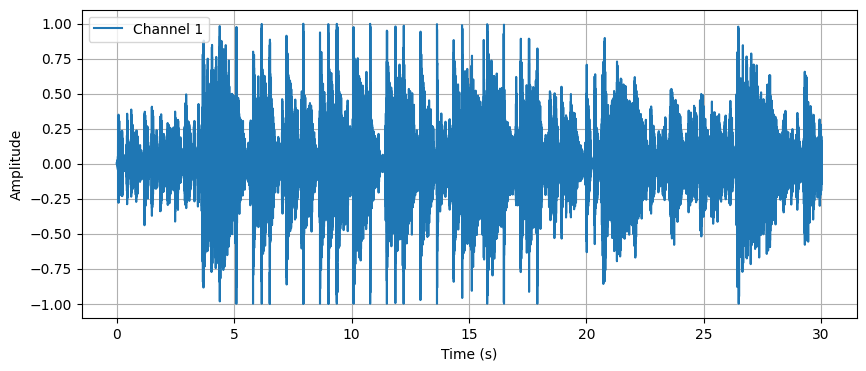

In [13]:
plot_signal(
    sig=audio_df.values, 
    sr=sr,
    mode="time",
    return_mode=False
)

In [14]:
from caits.fe import underlying_spectral


mags, freqs, summags = underlying_spectral(array=audio_df.values, fs=sr)

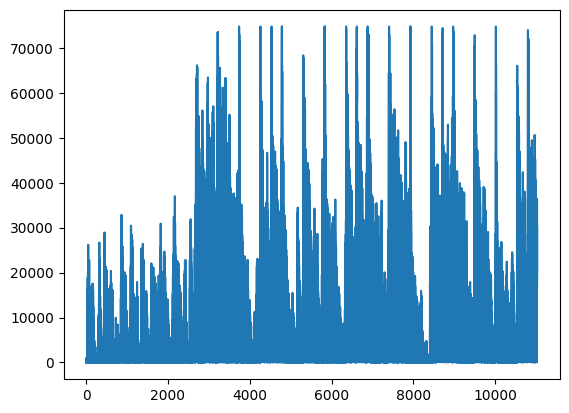

In [15]:
import matplotlib.pyplot as plt

plt.plot(freqs, mags[0:mags.shape[0]//2+1, 0] * summags)

In [16]:
from caits.fe import spectral_centroid

spectral_centroid(array=audio_df.values.flatten(), fs=sr)

2908.0423208230363

In [17]:
# frames = range(len(sc_centroid[0]))
# t = librosa.frames_to_time(frames, sr=sr, hop_length=512)

In [29]:
from typing import Optional
import numpy as np
from caits.fe.core_spectrum import fft_frequencies
from caits.fe._spectrum import spectrogram

from caits.core._core_typing import _WindowSpec, _PadModeSTFT
from caits.fe.core_spectrum import expand_to
from caits.core._core_window import normalize


def spectral_centroid(
    y: Optional[np.ndarray] = None,
    sr: float = 22050,
    S: Optional[np.ndarray] = None,
    n_fft: int = 2048,
    hop_length: int = 512,
    freq: Optional[np.ndarray] = None,
    win_length: Optional[int] = None,
    window: _WindowSpec = "hann",
    center: bool = True,
    pad_mode: _PadModeSTFT = "constant",
) -> np.ndarray:
    """Compute the spectral centroid.

    Each frame of a magnitude spectrogram is normalized and treated as a
    distribution over frequency bins, from which the mean (centroid) is
    extracted per frame.

    More precisely, the centroid at frame ``t`` is defined as [#]_::

        centroid[t] = sum_k S[k, t] * freq[k] / (sum_j S[j, t])

    where ``S`` is a magnitude spectrogram, and ``freq`` is the array of
    frequencies (e.g., FFT frequencies in Hz) of the rows of ``S``.

    .. [#] Klapuri, A., & Davy, M. (Eds.). (2007). Signal processing
        methods for music transcription, chapter 5.
        Springer Science & Business Media.
    """
    S, n_fft = spectrogram(
        y=y,
        S=S,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=center,
        pad_mode=pad_mode,
    )

    if not np.isrealobj(S):
        raise ValueError(
            "Spectral centroid is only defined " "with real-valued input"
        )
    elif np.any(S < 0):
        raise ValueError(
            "Spectral centroid is only defined " "with non-negative energies"
        )

    # Compute the center frequencies of each bin
    if freq is None:
        freq = fft_frequencies(sr=sr, n_fft=n_fft)
    print(freq.shape)
    if freq.ndim == 1:
        # reshape for broadcasting
        freq = expand_to(freq, ndim=S.ndim, axes=-2)
    print(freq.shape)
    # Column-normalize S
    centroid: np.ndarray = np.sum(
        freq * normalize(S, norm=1, axis=-2), axis=-2) # , keepdims=True
    # )
    return centroid

In [30]:
sc_lib = spectral_centroid(y=audio_df.values.flatten(), sr=sr)
sc_lib.shape

(1025,)
(1025, 1)


(1293,)

In [20]:
from caits.dataset import Dataset

X = Dataset(
    X=[audio_df],
    y=[0],
    id=["hiphp.wav"]
)

In [31]:
from sklearn.pipeline import Pipeline
from caits.transformers import SlidingWindow, FunctionTransformer

pipe = Pipeline([
    # ("chunker", SlidingWindow(window_size=int(1*sr), overlap=0)),
    ("spectral_centroid", FunctionTransformer(func=spectral_centroid, sr=sr))
]
)

In [32]:
x_transformed = pipe.fit_transform(X)
x_transformed[0]

(1025,)
(1025, 1)


(             ch_1
 0     3009.402945
 1     3480.924326
 2     3310.694860
 3     3017.145087
 4     3727.318502
 ...           ...
 1288  4383.944440
 1289  4872.430437
 1290  4925.995994
 1291  4941.658548
 1292  4919.874780
 
 [1293 rows x 1 columns],
 0,
 'hiphp.wav')